#Load from ZIP file#

In [0]:
# !unzip dummy_Inria_data.zip

#Deep UNet#

In [2]:
import os
import sys
import cv2
import time
import random
import keras
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras import backend as keras
from skimage.transform import resize
from keras.utils import plot_model, Sequence
import keras.backend.tensorflow_backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate
from skimage.transform import resize, rotate, rescale, warp, AffineTransform

from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

Using TensorFlow backend.


In [0]:
class DataAugmentation():
    """ Class for data augmentation.

        Mainly helps when the training data is small

        Parameters: image, mask,
                    rotation angle (default = 90)
                    zoom_range (default = 1)
                    horizontal_flip (default = False)
                    vertical_flip (default = False)
                    activate (default = False)
    """

    def __init__(self, image, mask,
                rotation = 0,
                zoom_range = 1,
                horizontal_flip = False,
                vertical_flip = False,
                shear = 0,
                activate = False):

        self.image = image
        self.mask = mask
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear
        self.activate = activate

    def rotate_data(self):
        """ Rotation
        """
        self.image = rotate(self.image, self.rotation)
        self.mask = rotate(self.mask, self.rotation)
        return self.image, self.mask

    def rescale_data(self):
        """ Rescaling
        """
        height, width, _ = self.image.shape
        self.image = rescale(self.image, self.zoom_range)
        self.image = resize(self.image, (height, width))

        self.mask = rescale(self.mask, self.zoom_range)
        self.mask = resize(self.mask, (height, width))
        return self.image, self.mask

    def flip_horizontal_data(self):
        """ Flip Horizontally
        """
        if self.horizontal_flip == True:
            flipped_image = np.flip(self.image, 1)
            flipped_mask = np.flip(self.mask, 1)
            return flipped_image, flipped_mask

    def flip_vertically_data(self):
        """ Flip Vertically
        """
        if self.vertical_flip == True:
            flipped_image = np.flip(self.image, 0)
            flipped_mask = np.flip(self.mask, 0)
            return flipped_image, flipped_mask

    def shear_data(self):
        """ Shear
        """
        trans = AffineTransform(shear = 0.2)
        self.image = warp(self.image, inverse_map= trans)
        self.mask = warp(self.mask, inverse_map= trans)
        return self.image, self.mask

    def augment(self):
        if self.activate == True:
            images = []
            masks = []
            images.append(self.image)
            masks.append(self.mask)
            # print('Augmentation:: Image List Size: ',len(images))
            if self.rotation != 0:
                self.image, self.mask = self.rotate_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.zoom_range != 1:
                self.image, self.mask = self.rescale_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.horizontal_flip == True:
                self.image, self.mask = self.flip_horizontal_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.vertical_flip == True:
                self.image, self.mask = self.flip_vertically_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.shear != 0:
                self.image, self.mask = self.shear_data()
                images.append(self.image)
                masks.append(self.mask)
        else:
            images = []
            masks = []
            images.append(self.image)
            masks.append(self.mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

In [0]:
from keras.utils import Sequence
class InriaDataLoader(Sequence):
    """ Load the training dataset for Inria Dataset from the
        data folder and put in an array

        Parameters: - data_path: Loads the datapath
                    - patch_size: Format the image sizes (default: 256x256)
                    - train_ids:

    """
    def __init__(self, data_ids, data_path, patch_size = 256,
                batch_size = 8, aug = False, rotation = 0,
                zoom_range = 1, horizontal_flip = False,
                vertical_flip = False, shear = 0):

        self.data_path = data_path
        self.data_ids = data_ids
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.aug = aug
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear

    def __load__(self, data_name):
        """ Load an image and a mask from the data folder
            Parameters: Image name
        """
        image_name_path = os.path.join(self.data_path,'images/', data_name)
        mask_name_path = os.path.join(self.data_path, 'gt', data_name)

        image = cv2.imread(image_name_path, 1)
        image = cv2.resize(image, (self.patch_size,
                            self.patch_size))

        mask = cv2.imread(mask_name_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (self.patch_size,
                            self.patch_size))
        mask = mask[:, :, np.newaxis]

        image = image/255.
        
        mask = mask/255.

        return image, mask

    def __getitem__(self, index):
        """ Get all the images and masks in the data folder
            and put into array
        """
        if(index+1)*self.batch_size > len(self.data_ids):
            self.batch_size = len(self.data_ids) - index*self.batch_size

        files_batch = self.data_ids[index * \
            self.batch_size: (index + 1) * self.batch_size]

        images = []
        masks = []

        for file in files_batch:
            image, mask = self.__load__(file)
    
            aug = DataAugmentation(image, mask,
                                   rotation =self.rotation,
                                   zoom_range = self.zoom_range,
                                   horizontal_flip = self.horizontal_flip,
                                   vertical_flip = self.vertical_flip,
                                   activate = self.aug)

            aug_images, aug_masks = aug.augment()

            for aug_image in aug_images:
                images.append(aug_image)

            for aug_mask in aug_masks:
                masks.append(aug_mask)
              

        images = np.array(images)
        masks = np.array(masks)

        return images, masks


    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.data_ids)/float(self.batch_size)))

In [0]:
class Visualizer():
    """ Class for visualizing input image and corresponding
        mask

        Parameters: image
                    mask
    """
    def __init__(self, image, mask, image_size = 256):
        self.image = image
        self.mask = mask
        self.image_size = image_size

    def plot(self):
        fig = plt.figure()
        fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

        fig_a = fig.add_subplot(1, 2, 1)
        fig_a.set_title('Input Image')
        image = np.reshape(self.image[0]*255, 
                           (self.image_size, self.image_size))
        plt.imshow(image)

        fig_b = fig.add_subplot(1, 2, 2)
        fig_b.set_title('Output Mask')
        mask = np.reshape(self.mask[0]*255, 
                          (self.image_size, self.image_size))
        plt.imshow(mask)

        plt.show()

In [0]:

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Lambda, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf


# def dice_coef(y_true, y_pred):
#     return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)
class DeepUNet():
    """ Deep U-Net Model

        Parameters: - Image Size (default = 256)
                    - Kernel Size (default = (3, 3))
                    - Padding (default = 'same')
                    - Activation (default = 'relu')
                    - Pool Size (default = 2)
                    - Strides (default = 1)
                    - Max Pool Strides (default = 2)
                    - Up Sample (default = 2)
    """
    def __init__(self, image_size=256,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu',
                 pool_size=2,
                 strides=1,
                 max_pool_strides=2,
                 up_sample=2):
        self.image_size = image_size
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.pool_size = pool_size
        self.strides = strides
        self.max_pool_strides = max_pool_strides
        self.up_sample = up_sample

    def network(self):
        # filters
        f = [16, 32, 64, 128, 256]
        # inputs
        inputs = Input((self.image_size, self.image_size, 3))

        # Encoder
        conv1 = Conv2D(f[0],
                       kernel_size=self.kernel_size,
                       padding=self.padding,
                       strides=self.strides)(inputs)
        bn1 = BatchNormalization()(conv1)
        act1 = Activation(self.activation)(bn1)

        conv2 = Conv2D(f[0],
                       kernel_size=(1,1),
                       padding=self.padding,
                       strides=self.strides)(inputs)
        bn2 = BatchNormalization()(conv2)

        sum1 = Add()([act1, bn2])

        # residaul block 1
        bn3 = BatchNormalization()(sum1)
        act3 = Activation(self.activation)(bn3)
        conv3 = Conv2D(f[1],
                       kernel_size=self.kernel_size,
                       padding=self.padding,
                       strides=2)(act3)
        bn4 = BatchNormalization()(conv3)
        act4 = Activation(self.activation)(bn4)
        conv4 = Conv2D(f[1],
                       kernel_size=self.kernel_size,
                       padding=self.padding,
                       strides=1)(act4)
        conv5 = Conv2D(f[1],
                       kernel_size=(1, 1),
                       padding=self.padding,
                       strides=2)(sum1)
        bn5 = BatchNormalization()(conv5)

        sum2 = Add()([bn5, conv4])

        # residual block 2
        bn6 = BatchNormalization()(sum2)
        act6 = Activation(self.activation)(bn6)
        conv6 = Conv2D(f[2],
                       kernel_size=self.kernel_size,
                       padding=self.padding,
                       strides=2)(act6)
        bn7 = BatchNormalization()(conv6)
        act7 = Activation(self.activation)(bn7)
        conv7 = Conv2D(f[2],
                       kernel_size=self.kernel_size,
                       padding=self.padding,
                       strides=1)(act7)
        conv8 = Conv2D(f[2],
                       kernel_size=(1, 1),
                       padding=self.padding,
                       strides=2)(sum2)
        bn8 = BatchNormalization()(conv8)

        sum3 = Add()([bn8, conv7])

        # residual block 3
        bn9 = BatchNormalization()(sum3)
        act9 = Activation(self.activation)(bn9)
        conv9 = Conv2D(f[3],
                       kernel_size=self.kernel_size,
                       padding=self.padding,
                       strides=2)(act9)
        bn10 = BatchNormalization()(conv9)
        act10 = Activation(self.activation)(bn10)
        conv10 = Conv2D(f[3],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act10)
        conv11 = Conv2D(f[3],
                        kernel_size=(1, 1),
                        padding=self.padding,
                        strides=2)(sum3)
        bn11 = BatchNormalization()(conv11)

        sum4 = Add()([bn11, conv10])

        # residual block 4
        bn12 = BatchNormalization()(sum4)
        act12 = Activation(self.activation)(bn12)
        conv12 = Conv2D(f[4],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=2)(act12)
        bn13 = BatchNormalization()(conv12)
        act13 = Activation(self.activation)(bn13)
        conv13 = Conv2D(f[4],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act13)
        conv14 = Conv2D(f[4],
                        kernel_size=(1, 1),
                        padding=self.padding,
                        strides=2)(sum4)
        bn14 = BatchNormalization()(conv14)

        sum5 = Add()([bn14, conv13])

        # Bridge
        bn15 = BatchNormalization()(sum5)
        act15 = Activation(self.activation)(bn15)
        conv15 = Conv2D(f[4],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act15)

        bn16 = BatchNormalization()(conv15)
        act16 = Activation(self.activation)(bn16)
        conv16 = Conv2D(f[4],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act16)

        # Decoder
        # decode block 1
        us1 = UpSampling2D((2, 2))(conv16)
        conc1 = Concatenate()([us1, sum4])

        bn17 = BatchNormalization()(conc1)
        act17 = Activation(self.activation)(bn17)
        conv17 = Conv2D(f[4],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act17)
        bn18 = BatchNormalization()(conv17)
        act18 = Activation(self.activation)(bn18)
        conv18 = Conv2D(f[4],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act18)
        conv19 = Conv2D(f[4],
                        kernel_size=(1, 1),
                        padding=self.padding,
                        strides=1)(sum4)
        bn19 = BatchNormalization()(conv19)

        sum6 = Add()([bn19, conv18])

        # decode block 2
        us2 = UpSampling2D((2, 2))(sum6)
        conc2 = Concatenate()([us2, sum3])

        bn20 = BatchNormalization()(conc2)
        act20 = Activation(self.activation)(bn20)
        conv20 = Conv2D(f[3],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act20)
        bn21 = BatchNormalization()(conv20)
        act21 = Activation(self.activation)(bn21)
        conv21 = Conv2D(f[3],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act21)
        conv22 = Conv2D(f[3],
                        kernel_size=(1, 1),
                        padding=self.padding,
                        strides=1)(sum3)
        bn22 = BatchNormalization()(conv22)

        sum7 = Add()([bn22, conv21])

        # decode block 3
        us3 = UpSampling2D((2, 2))(sum7)
        conc3 = Concatenate()([us3, sum2])

        bn23 = BatchNormalization()(conc3)
        act23 = Activation(self.activation)(bn23)
        conv23 = Conv2D(f[2],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act23)
        bn24 = BatchNormalization()(conv23)
        act24 = Activation(self.activation)(bn24)
        conv24 = Conv2D(f[2],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act24)
        conv25 = Conv2D(f[2],
                        kernel_size=(1, 1),
                        padding=self.padding,
                        strides=1)(sum2)
        bn25 = BatchNormalization()(conv25)

        sum8 = Add()([bn25, conv24])

        # decode block 4
        us4 = UpSampling2D((2, 2))(sum8)
        conc4 = Concatenate()([us4, sum1])

        bn26 = BatchNormalization()(conc4)
        act26 = Activation(self.activation)(bn26)
        conv26 = Conv2D(f[1],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act26)
        bn27 = BatchNormalization()(conv26)
        act27 = Activation(self.activation)(bn27)
        conv27 = Conv2D(f[1],
                        kernel_size=self.kernel_size,
                        padding=self.padding,
                        strides=1)(act27)
        conv28 = Conv2D(f[1],
                        kernel_size=(1, 1),
                        padding=self.padding,
                        strides=1)(sum1)
        bn28 = BatchNormalization()(conv28)

        sum9 = Add()([bn28, conv27])

        # Final Layer
        outputs = Conv2D(1,
                         kernel_size=(1, 1),
                         padding="same",
                         activation="sigmoid")(sum9)
        model = Model(inputs, outputs)
        return model


In [0]:
# """
# Name: Train U-Net Model
# Author: Arghadeep Mazumder
# Version: 0.1
# Description: Train U-Net Model

# """
# import os
# import sys
# import cv2
# import keras.utils
# import numpy as np
# sys.path.append('../')
# from utils.iou import IoU
# from models.fcn import FCN
# from utils.loader import InriaDataLoader
# from keras.models import Model
# from keras.layers import *
# from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
# from utils.visualizer import InriaVisualizer

class TrainDeepUNet():
    """ Class for training U-Net Model

        Parameters: train_path       = train folder
                    patch_size      = 256
                    activate_aug    = False
                    rotation        = 0
                    zoom_range      = 1
                    horizontal_flip = False
                    vertical_flip   = False
                    shear           = 0
                    net             = U-Net
                    epochs          = 5
                    batch_size      = 1
                    learning_rate   = 0.2
                    val_percent     =
                    save_model      = False
                    activate_gpu    = False
    """
    def __init__(self,
                train_path,
                image_size = 256,
                activate_aug = False,
                rotation = 0,
                zoom_range = 1,
                horizontal_flip = False,
                vertical_flip = False,
                shear = 0,
                epochs = 10,
                batch_size = 8,
                learning_rate = 0.1,
                save_model = True,
                val_data_size = 10,
                evaluate = True):

        self.train_path = train_path
        self.image_size = image_size
        self.activate_aug = activate_aug
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.save_model = save_model
        self.val_data_size = val_data_size
        self.evaluate = evaluate

    def train(self):
        print('''
Start Training:

    Data Path:       {}
    Model:           {}
    Patch Size:      {}
    Augmentation:    {}
    Rotation:        {}
    Zoom Range:      {}
    Horizontal Flip: {}
    Vertical Flip:   {}
    Shear:           {}
    Epochs:          {}
    Batch Size:      {}
    Learning Rate:   {}
    Validation %:    {}
    Save Model:      {}
    Evaluate:        {}

        '''.format(str(self.train_path), str('U-Net'), self.image_size,
            self.activate_aug, self.rotation, self.zoom_range,
            self.horizontal_flip, self.vertical_flip, self.shear,
            self.epochs, self.batch_size, self.learning_rate,
            self.val_data_size, self.save_model, self.evaluate))

        images_path = os.path.join(self.train_path, 'images/')
        train_ids = next(os.walk(images_path))[2]

        valid_ids = train_ids[:self.val_data_size]
        train_ids = train_ids[self.val_data_size:]


        models = DeepUNet()
        model = models.network()
        model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy',
                    metrics = ['acc'])
        model.summary()

        train_gen = InriaDataLoader(train_ids,
                                    self.train_path,
                                    patch_size = self.image_size,
                                    batch_size = self.batch_size)

        valid_gen = InriaDataLoader(valid_ids,
                                    self.train_path,
                                    patch_size = self.image_size,
                                    batch_size = self.batch_size)

        train_steps = len(train_ids) // self.batch_size
        valid_steps = len(valid_ids) // self.batch_size
        print(train_steps)
        model.fit_generator(train_gen,
                            validation_data = valid_gen,
                            steps_per_epoch = train_steps,
                            validation_steps = valid_steps,
                            epochs = self.epochs)
        if self.save_model:
            model.save('building_deepunet.h5')

#         keras.utils.plot_model(model, to_file = 'unet_architecture.png')

        if self.evaluate:
            image , mask = valid_gen.__getitem__(2)
            result = model.predict(image)
            result = result > 0.5
            viz = Visualizer(mask, result)
            viz.plot()

#         iou_score = IoU(target= mask, prediction=result)
#         print('IoU Score: ',iou_score)


W0723 18:13:20.914110 140245804066688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 18:13:20.956295 140245804066688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 18:13:20.963299 140245804066688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 18:13:21.009352 140245804066688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 18:13:21.012181 1402458040


Start Training:

    Data Path:       dummy_Inria_data/train
    Model:           U-Net
    Patch Size:      256
    Augmentation:    False
    Rotation:        0
    Zoom Range:      1
    Horizontal Flip: False
    Vertical Flip:   False
    Shear:           0
    Epochs:          10
    Batch Size:      8
    Learning Rate:   0.1
    Validation %:    10
    Save Model:      True
    Evaluate:        True

        


W0723 18:13:24.216511 140245804066688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0723 18:13:25.709342 140245804066688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0723 18:13:26.878841 140245804066688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 18:13:26.906870 140245804066688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be rem

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 64          input_1[0][0]                    
__________________________________________________________________________________________________
activation

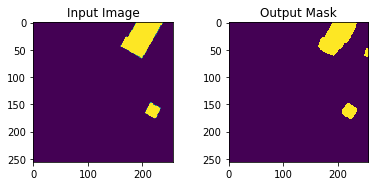

In [8]:
train_fcn = TrainDeepUNet(train_path='dummy_Inria_data/train')
train_fcn.train()